# Frequency & Exposure

- dataset A

In [1]:
import os
from IPython.display import display, HTML

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm

In [3]:
import arff

## Frequency

In [ ]:
folders = f"{os.getcwd()}".split('/')[:-1]
folders.extend(['datasets', 'D', 'freMTPL2freq.arff'])
path1 = os.path.join(*folders)
path1 = '/'+path1
print(path1)

['', 'Users', 'school', 'Desktop', 'Github Repositories', 'CSE-5099']
/Users/school/Desktop/Github Repositories/CSE-5099/datasets/D/freMTPL2freq.arff


In [6]:
with open(path1, 'r') as f:
    arff_data = arff.load(f)

freq_df = pd.DataFrame(arff_data['data'], columns=[attr[0] for attr in arff_data['attributes']])

print(freq_df.shape)
display(HTML(freq_df[:10].to_html()))

(678013, 12)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region
0,1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
1,3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82
2,5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22
3,10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
4,11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72
5,13.0,1.0,0.52,E,6.0,2.0,38.0,50.0,B12,Regular,3003.0,R31
6,15.0,1.0,0.45,E,6.0,2.0,38.0,50.0,B12,Regular,3003.0,R31
7,17.0,1.0,0.27,C,7.0,0.0,33.0,68.0,B12,Diesel,137.0,R91
8,18.0,1.0,0.71,C,7.0,0.0,33.0,68.0,B12,Diesel,137.0,R91
9,21.0,1.0,0.15,B,7.0,0.0,41.0,50.0,B12,Diesel,60.0,R52


## Severity

In [7]:
folders = f"{os.getcwd()}".split('/')[:-1]
folders.extend(['datasets', 'D', 'freMTPL2sev.arff'])
path2 = os.path.join(*folders)
path2 = '/'+path2
print(path2)

/Users/school/Desktop/Github Repositories/CSE-5099/datasets/D/freMTPL2sev.arff


In [8]:
with open(path2, 'r') as f:
    arff_data = arff.load(f)

sev_df = pd.DataFrame(arff_data['data'], columns=[attr[0] for attr in arff_data['attributes']])

print(sev_df.shape)
display(HTML(sev_df[:10].to_html()))

(26639, 2)


,IDpol,ClaimAmount
0,1552.0,995.20
1,1010996.0,1128.12
2,4024277.0,1851.11
3,4007252.0,1204.00
4,4046424.0,1204.00
5,4073956.0,1204.00
6,4012173.0,1204.00
7,4020812.0,54942.62
8,4020812.0,7620.00
9,4074074.0,1204.00


### Combine

In [9]:
sev_df = sev_df.groupby(
    by= 'IDpol'
).sum()

print(sev_df.shape)
display(HTML(sev_df.iloc[:10].to_html()))

(24950, 1)


,ClaimAmount
IDpol,
139.0,303.00
190.0,1981.84
414.0,1456.55
424.0,10834.00
463.0,3986.67
606.0,1840.14
622.0,1397.97
811.0,971.98
830.0,1442.75


In [10]:
data_df = freq_df.join(sev_df, how="left")
data_df["ClaimAmount"] = data_df["ClaimAmount"].fillna(0)

del freq_df, sev_df

print(data_df.shape)
display(HTML(data_df.iloc[:20].to_html()))

(678013, 13)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount
0.0,1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
1.0,3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0
2.0,5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0
3.0,10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
4.0,11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0
5.0,13.0,1.0,0.52,E,6.0,2.0,38.0,50.0,B12,Regular,3003.0,R31,0.0
6.0,15.0,1.0,0.45,E,6.0,2.0,38.0,50.0,B12,Regular,3003.0,R31,0.0
7.0,17.0,1.0,0.27,C,7.0,0.0,33.0,68.0,B12,Diesel,137.0,R91,0.0
8.0,18.0,1.0,0.71,C,7.0,0.0,33.0,68.0,B12,Diesel,137.0,R91,0.0
9.0,21.0,1.0,0.15,B,7.0,0.0,41.0,50.0,B12,Diesel,60.0,R52,0.0


### Finishing Touches

In [11]:
data_df["PurePremium"]= data_df["ClaimAmount"]/data_df["Exposure"]
data_df["Frequency"]= data_df["ClaimNb"]/data_df["Exposure"]

print(data_df.shape)
display(HTML(data_df.iloc[:10].to_html()))

(678013, 15)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency
0.0,1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0,10.000000
1.0,3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0,1.298701
2.0,5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0,0.0,1.333333
3.0,10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0,11.111111
4.0,11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0,1.190476
5.0,13.0,1.0,0.52,E,6.0,2.0,38.0,50.0,B12,Regular,3003.0,R31,0.0,0.0,1.923077
6.0,15.0,1.0,0.45,E,6.0,2.0,38.0,50.0,B12,Regular,3003.0,R31,0.0,0.0,2.222222
7.0,17.0,1.0,0.27,C,7.0,0.0,33.0,68.0,B12,Diesel,137.0,R91,0.0,0.0,3.703704
8.0,18.0,1.0,0.71,C,7.0,0.0,33.0,68.0,B12,Diesel,137.0,R91,0.0,0.0,1.408451
9.0,21.0,1.0,0.15,B,7.0,0.0,41.0,50.0,B12,Diesel,60.0,R52,0.0,0.0,6.666667


In [12]:
data_df = data_df.dropna(
            axis= 0,
        )

In [13]:
print(data_df.shape)
display(HTML(data_df.iloc[:10].to_html()))

(678013, 15)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency
0.0,1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0,10.000000
1.0,3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0,1.298701
2.0,5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0,0.0,1.333333
3.0,10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0,11.111111
4.0,11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0,1.190476
5.0,13.0,1.0,0.52,E,6.0,2.0,38.0,50.0,B12,Regular,3003.0,R31,0.0,0.0,1.923077
6.0,15.0,1.0,0.45,E,6.0,2.0,38.0,50.0,B12,Regular,3003.0,R31,0.0,0.0,2.222222
7.0,17.0,1.0,0.27,C,7.0,0.0,33.0,68.0,B12,Diesel,137.0,R91,0.0,0.0,3.703704
8.0,18.0,1.0,0.71,C,7.0,0.0,33.0,68.0,B12,Diesel,137.0,R91,0.0,0.0,1.408451
9.0,21.0,1.0,0.15,B,7.0,0.0,41.0,50.0,B12,Diesel,60.0,R52,0.0,0.0,6.666667


In [14]:
categorical_cols = list(data_df.columns[data_df.dtypes == 'object'])
print(f"Categorical: {categorical_cols}")

numerical_cols= list(data_df.columns[data_df.dtypes == 'float64'])
print(f"Numerical: {numerical_cols}")


Categorical: ['Area', 'VehBrand', 'VehGas', 'Region']
Numerical: ['IDpol', 'ClaimNb', 'Exposure', 'VehPower', 'VehAge', 'DrivAge', 'BonusMalus', 'Density', 'ClaimAmount', 'PurePremium', 'Frequency']


In [15]:
if False:
    for col in categorical_cols:
        plt.figure(figsize=(6, 4))
        sns.histplot(
            data= data_df[col],
        )    
        plt.title(f'{col} distribution')
        plt.show()

In [16]:
b_size =[
    50, # IDpol
    10, # ClaimNb
    50, # Exposure
    50, # VehPower
    50, # VehAge
    50, # DrivAge
    50, # BonusMalus
    50 # Density
]

if False:
    for col, b_size in zip(numerical_cols, b_size):
        plt.figure(figsize=(6, 4))
        plt.title(f'{col} distribution')
        sns.histplot(
            data= data_df[col],
            bins= b_size,
            kde=True
        )
        plt.title(f'{col} distribution')
        plt.show()


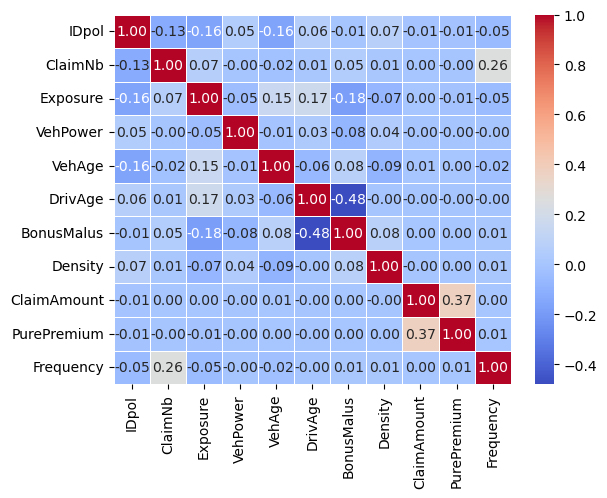

In [17]:
numerical_df = data_df[numerical_cols]
correlations = numerical_df.corr(
    method= 'pearson'
)

sns.heatmap(
    data = correlations,
    annot= True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5
)
plt.show()

### Back to data

- Feature Engineering

In [18]:
print(data_df.columns)

Index(['IDpol', 'ClaimNb', 'Exposure', 'Area', 'VehPower', 'VehAge', 'DrivAge',
       'BonusMalus', 'VehBrand', 'VehGas', 'Density', 'Region', 'ClaimAmount',
       'PurePremium', 'Frequency'],
      dtype='object')


### Encoding Categorical Columns

In [19]:
use_OHE = False

In [20]:
# Encoding
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder

data2_df = data_df.copy()

# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html
OHE = OneHotEncoder(
    # *, 
    # categories='auto', 
    drop= 'if_binary', 
    # sparse_output= True, 
    # dtype=<class 'numpy.float64'>, 
    # handle_unknown='error', 
    # min_frequency=None, 
    # max_categories=None, 
    # feature_name_combiner='concat'
)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#ordinalencoder
OE = OrdinalEncoder(
    # *,
    categories='auto',
    # dtype=<class 'numpy.float64'>,
    # handle_unknown='error',
    # unknown_value=None,
    # encoded_missing_value=nan,
    # min_frequency=None,
    # max_categories=None
)

for col in data2_df.columns:
    if data2_df[col].dtype == 'object':
        
        if use_OHE:
            # https://www.geeksforgeeks.org/ml-one-hot-encoding/
            col_encoded = OHE.fit_transform(data2_df[[col]]).toarray()
            encoded_df = pd.DataFrame(
                col_encoded, 
                columns= OHE.get_feature_names_out([col]), 
                index= data2_df.index
            )
            data2_df = data2_df.drop(columns=col)
            data2_df = pd.concat([data2_df, encoded_df], axis=1)
        
        else:
            col_encoded = OE.fit_transform(data2_df[[col]])
            encoded_df = pd.DataFrame(
                col_encoded, 
                columns= OE.get_feature_names_out([col]), 
                index= data2_df.index
            )
            data2_df[col] = encoded_df
            
display(HTML(data_df.iloc[:8].to_html()))
display(HTML(data2_df.iloc[:8].to_html()))

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency
0.0,1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0,10.000000
1.0,3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0,1.298701
2.0,5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0,0.0,1.333333
3.0,10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0,11.111111
4.0,11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0,1.190476
5.0,13.0,1.0,0.52,E,6.0,2.0,38.0,50.0,B12,Regular,3003.0,R31,0.0,0.0,1.923077
6.0,15.0,1.0,0.45,E,6.0,2.0,38.0,50.0,B12,Regular,3003.0,R31,0.0,0.0,2.222222
7.0,17.0,1.0,0.27,C,7.0,0.0,33.0,68.0,B12,Diesel,137.0,R91,0.0,0.0,3.703704


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency
0.0,1.0,1.0,0.10,3.0,5.0,0.0,55.0,50.0,3.0,1.0,1217.0,17.0,0.0,0.0,10.000000
1.0,3.0,1.0,0.77,3.0,5.0,0.0,55.0,50.0,3.0,1.0,1217.0,17.0,0.0,0.0,1.298701
2.0,5.0,1.0,0.75,1.0,6.0,2.0,52.0,50.0,3.0,0.0,54.0,2.0,0.0,0.0,1.333333
3.0,10.0,1.0,0.09,1.0,7.0,0.0,46.0,50.0,3.0,0.0,76.0,14.0,0.0,0.0,11.111111
4.0,11.0,1.0,0.84,1.0,7.0,0.0,46.0,50.0,3.0,0.0,76.0,14.0,0.0,0.0,1.190476
5.0,13.0,1.0,0.52,4.0,6.0,2.0,38.0,50.0,3.0,1.0,3003.0,7.0,0.0,0.0,1.923077
6.0,15.0,1.0,0.45,4.0,6.0,2.0,38.0,50.0,3.0,1.0,3003.0,7.0,0.0,0.0,2.222222
7.0,17.0,1.0,0.27,2.0,7.0,0.0,33.0,68.0,3.0,0.0,137.0,19.0,0.0,0.0,3.703704


### Adding Non-Linear Terms
- Splines?
- Feature Engineering
- Polynomials
- Interactions

In [21]:
import random

random.seed(14)

test = data2_df[
    random.sample(
    population= list(data2_df.columns),
    k= 3
    )
]

display(HTML(test.iloc[:10].to_html()))

,ClaimNb,VehGas,Region
0.0,1.0,1.0,17.0
1.0,1.0,1.0,17.0
2.0,1.0,0.0,2.0
3.0,1.0,0.0,14.0
4.0,1.0,0.0,14.0
5.0,1.0,1.0,7.0
6.0,1.0,1.0,7.0
7.0,1.0,0.0,19.0
8.0,1.0,0.0,19.0
9.0,1.0,0.0,11.0


In [22]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html 
from sklearn.preprocessing import PolynomialFeatures

if True:
    poly = PolynomialFeatures(
        degree= 3,
        # interaction_only=,
        include_bias= False,
        # order= ,
    )

    test_2 = poly.fit_transform(test)    
    test_2 = pd.DataFrame(
        data= test_2,
        columns= poly.get_feature_names_out()
    )
    
    
    print(test.shape)
    display(HTML(test.iloc[:10].to_html()))
    
    print(test_2.shape)
    display(HTML(test_2.iloc[:10].to_html()))

(678013, 3)


,ClaimNb,VehGas,Region
0.0,1.0,1.0,17.0
1.0,1.0,1.0,17.0
2.0,1.0,0.0,2.0
3.0,1.0,0.0,14.0
4.0,1.0,0.0,14.0
5.0,1.0,1.0,7.0
6.0,1.0,1.0,7.0
7.0,1.0,0.0,19.0
8.0,1.0,0.0,19.0
9.0,1.0,0.0,11.0


(678013, 19)


,ClaimNb,VehGas,Region,ClaimNb^2,ClaimNb VehGas,ClaimNb Region,VehGas^2,VehGas Region,Region^2,ClaimNb^3,ClaimNb^2 VehGas,ClaimNb^2 Region,ClaimNb VehGas^2,ClaimNb VehGas Region,ClaimNb Region^2,VehGas^3,VehGas^2 Region,VehGas Region^2,Region^3
0,1.0,1.0,17.0,1.0,1.0,17.0,1.0,17.0,289.0,1.0,1.0,17.0,1.0,17.0,289.0,1.0,17.0,289.0,4913.0
1,1.0,1.0,17.0,1.0,1.0,17.0,1.0,17.0,289.0,1.0,1.0,17.0,1.0,17.0,289.0,1.0,17.0,289.0,4913.0
2,1.0,0.0,2.0,1.0,0.0,2.0,0.0,0.0,4.0,1.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,8.0
3,1.0,0.0,14.0,1.0,0.0,14.0,0.0,0.0,196.0,1.0,0.0,14.0,0.0,0.0,196.0,0.0,0.0,0.0,2744.0
4,1.0,0.0,14.0,1.0,0.0,14.0,0.0,0.0,196.0,1.0,0.0,14.0,0.0,0.0,196.0,0.0,0.0,0.0,2744.0
5,1.0,1.0,7.0,1.0,1.0,7.0,1.0,7.0,49.0,1.0,1.0,7.0,1.0,7.0,49.0,1.0,7.0,49.0,343.0
6,1.0,1.0,7.0,1.0,1.0,7.0,1.0,7.0,49.0,1.0,1.0,7.0,1.0,7.0,49.0,1.0,7.0,49.0,343.0
7,1.0,0.0,19.0,1.0,0.0,19.0,0.0,0.0,361.0,1.0,0.0,19.0,0.0,0.0,361.0,0.0,0.0,0.0,6859.0
8,1.0,0.0,19.0,1.0,0.0,19.0,0.0,0.0,361.0,1.0,0.0,19.0,0.0,0.0,361.0,0.0,0.0,0.0,6859.0
9,1.0,0.0,11.0,1.0,0.0,11.0,0.0,0.0,121.0,1.0,0.0,11.0,0.0,0.0,121.0,0.0,0.0,0.0,1331.0


In [23]:
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.SplineTransformer.html#sklearn.preprocessing.SplineTransformer
from sklearn.preprocessing import SplineTransformer

if True:
    spline = SplineTransformer(
        n_knots= 3,
        degree= 3,
        # knots=,
        # extrapolation=,
        # include_bias=,
        # order=,
        # sparse_output=
    )
    test_3 = spline.fit_transform(test)    
    test_3 = pd.DataFrame(
        data= test_3,
        columns= list(spline.get_feature_names_out())
    )
    
    print(test.shape)
    display(HTML(test.iloc[:10].to_html()))
    
    print(test_3.shape)
    display(HTML(test_3.iloc[:10].to_html()))

(678013, 3)


,ClaimNb,VehGas,Region
0.0,1.0,1.0,17.0
1.0,1.0,1.0,17.0
2.0,1.0,0.0,2.0
3.0,1.0,0.0,14.0
4.0,1.0,0.0,14.0
5.0,1.0,1.0,7.0
6.0,1.0,1.0,7.0
7.0,1.0,0.0,19.0
8.0,1.0,0.0,19.0
9.0,1.0,0.0,11.0


(678013, 15)


,ClaimNb_sp_0,ClaimNb_sp_1,ClaimNb_sp_2,ClaimNb_sp_3,ClaimNb_sp_4,VehGas_sp_0,VehGas_sp_1,VehGas_sp_2,VehGas_sp_3,VehGas_sp_4,Region_sp_0,Region_sp_1,Region_sp_2,Region_sp_3,Region_sp_4
0,0.111654,0.652018,0.236003,0.000326,0.0,0.000000,0.000000,0.166667,0.666667,0.166667,0.000000,0.009214,0.402062,0.549185,0.039539
1,0.111654,0.652018,0.236003,0.000326,0.0,0.000000,0.000000,0.166667,0.666667,0.166667,0.000000,0.009214,0.402062,0.549185,0.039539
2,0.111654,0.652018,0.236003,0.000326,0.0,0.166667,0.666667,0.166667,0.000000,0.000000,0.088417,0.633841,0.276590,0.001152,0.000000
3,0.111654,0.652018,0.236003,0.000326,0.0,0.166667,0.666667,0.166667,0.000000,0.000000,0.000000,0.049383,0.574074,0.370370,0.006173
4,0.111654,0.652018,0.236003,0.000326,0.0,0.166667,0.666667,0.166667,0.000000,0.000000,0.000000,0.049383,0.574074,0.370370,0.006173
5,0.111654,0.652018,0.236003,0.000326,0.0,0.000000,0.000000,0.166667,0.666667,0.166667,0.006173,0.370370,0.574074,0.049383,0.000000
6,0.111654,0.652018,0.236003,0.000326,0.0,0.000000,0.000000,0.166667,0.666667,0.166667,0.006173,0.370370,0.574074,0.049383,0.000000
7,0.111654,0.652018,0.236003,0.000326,0.0,0.166667,0.666667,0.166667,0.000000,0.000000,0.000000,0.001152,0.276590,0.633841,0.088417
8,0.111654,0.652018,0.236003,0.000326,0.0,0.166667,0.666667,0.166667,0.000000,0.000000,0.000000,0.001152,0.276590,0.633841,0.088417
9,0.111654,0.652018,0.236003,0.000326,0.0,0.166667,0.666667,0.166667,0.000000,0.000000,0.000000,0.143973,0.664453,0.191556,0.000018


## Metrics to look for in GLM

In [24]:
print('data2_df')
print(data_df.shape)
display(HTML(data2_df.iloc[:10].to_html()))

data2_df
(678013, 15)


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency
0.0,1.0,1.0,0.10,3.0,5.0,0.0,55.0,50.0,3.0,1.0,1217.0,17.0,0.0,0.0,10.000000
1.0,3.0,1.0,0.77,3.0,5.0,0.0,55.0,50.0,3.0,1.0,1217.0,17.0,0.0,0.0,1.298701
2.0,5.0,1.0,0.75,1.0,6.0,2.0,52.0,50.0,3.0,0.0,54.0,2.0,0.0,0.0,1.333333
3.0,10.0,1.0,0.09,1.0,7.0,0.0,46.0,50.0,3.0,0.0,76.0,14.0,0.0,0.0,11.111111
4.0,11.0,1.0,0.84,1.0,7.0,0.0,46.0,50.0,3.0,0.0,76.0,14.0,0.0,0.0,1.190476
5.0,13.0,1.0,0.52,4.0,6.0,2.0,38.0,50.0,3.0,1.0,3003.0,7.0,0.0,0.0,1.923077
6.0,15.0,1.0,0.45,4.0,6.0,2.0,38.0,50.0,3.0,1.0,3003.0,7.0,0.0,0.0,2.222222
7.0,17.0,1.0,0.27,2.0,7.0,0.0,33.0,68.0,3.0,0.0,137.0,19.0,0.0,0.0,3.703704
8.0,18.0,1.0,0.71,2.0,7.0,0.0,33.0,68.0,3.0,0.0,137.0,19.0,0.0,0.0,1.408451
9.0,21.0,1.0,0.15,1.0,7.0,0.0,41.0,50.0,3.0,0.0,60.0,11.0,0.0,0.0,6.666667


In [25]:
# ex

y_col = 'ClaimNb'
y = pd.DataFrame(
    data= {
        y_col: data2_df[y_col]
    }
)

X = data2_df.copy().drop(
    labels= [y_col],
    axis= 1,
)
X = sm.add_constant(
    data= X
)

print(y.shape)
display(HTML(y.iloc[:8].to_html()))

print(X.shape)
display(HTML(X.iloc[:8].to_html()))

(678013, 1)


,ClaimNb
0.0,1.0
1.0,1.0
2.0,1.0
3.0,1.0
4.0,1.0
5.0,1.0
6.0,1.0
7.0,1.0


(678013, 15)


,const,IDpol,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency
0.0,1.0,1.0,0.10,3.0,5.0,0.0,55.0,50.0,3.0,1.0,1217.0,17.0,0.0,0.0,10.000000
1.0,1.0,3.0,0.77,3.0,5.0,0.0,55.0,50.0,3.0,1.0,1217.0,17.0,0.0,0.0,1.298701
2.0,1.0,5.0,0.75,1.0,6.0,2.0,52.0,50.0,3.0,0.0,54.0,2.0,0.0,0.0,1.333333
3.0,1.0,10.0,0.09,1.0,7.0,0.0,46.0,50.0,3.0,0.0,76.0,14.0,0.0,0.0,11.111111
4.0,1.0,11.0,0.84,1.0,7.0,0.0,46.0,50.0,3.0,0.0,76.0,14.0,0.0,0.0,1.190476
5.0,1.0,13.0,0.52,4.0,6.0,2.0,38.0,50.0,3.0,1.0,3003.0,7.0,0.0,0.0,1.923077
6.0,1.0,15.0,0.45,4.0,6.0,2.0,38.0,50.0,3.0,1.0,3003.0,7.0,0.0,0.0,2.222222
7.0,1.0,17.0,0.27,2.0,7.0,0.0,33.0,68.0,3.0,0.0,137.0,19.0,0.0,0.0,3.703704


# GLM Example

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               508509
Model:                            GLM   Df Residuals:                   508495
Model Family:                Gaussian   Df Model:                           13
Link Function:               Identity   Scale:                        0.052675
Method:                          IRLS   Log-Likelihood:                 26891.
Date:                Sun, 11 May 2025   Deviance:                       26785.
Time:                        23:23:25   Pearson chi2:                 2.68e+04
No. Iterations:                     3   Pseudo R-squ. (CS):            0.09145
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0052      0.003     -1.924      

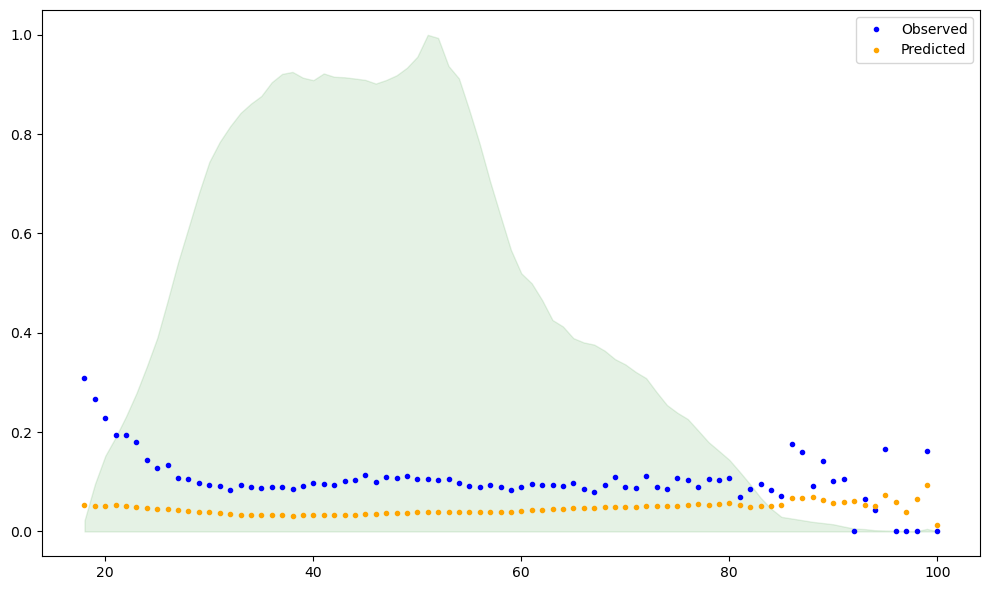

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               508509
Model:                            GLM   Df Residuals:                   508495
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0126e+05
Date:                Sun, 11 May 2025   Deviance:                   1.5071e+05
Time:                        23:23:26   Pearson chi2:                 7.63e+05
No. Iterations:                   100   Pseudo R-squ. (CS):            0.03369
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.3645      0.045    -73.994      

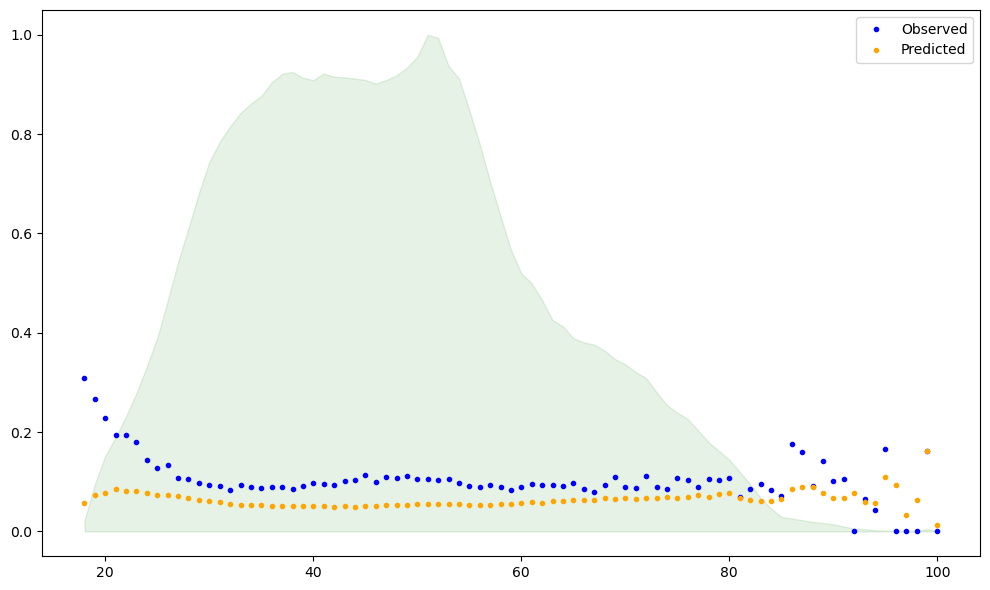

In [26]:
from sklearn.model_selection import train_test_split

# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y, 
    random_state= 123
)

X_train_e = X_train['Exposure']
X_train.drop(
    labels= ['Exposure'],
    axis= 1,
    inplace= True
)
X_test_e = X_test['Exposure']
X_test.drop(
    labels= ['Exposure'],
    axis= 1,
    inplace= True
)

# https://www.statsmodels.org/stable/generated/statsmodels.genmod.generalized_linear_model.GLM.html#statsmodels.genmod.generalized_linear_model.GLM
glm_ex1 = sm.GLM(
    endog= y_train,
    exog= X_train,
    family= sm.families.Gaussian(),
    # offset=,
    # exposure=,
    # freq_weights=,
    # var_weights=,
    # missing=,
).fit()

glm_ex2 = sm.GLM(
    endog= y_train,
    exog= X_train,
    family= sm.families.Poisson(),
    # offset=,
    exposure= X_train_e,
    # freq_weights=,
    # var_weights=,
    # missing=,
).fit()

def pred_obs_plot(
    df : pd.DataFrame,
    feature,
    weight,
    observed,
    predict
    ):
    
    df_1 = df[[feature, weight]].copy()
    df_1['observed'] = df[observed] * df[weight]
    df_1['predicted'] = predict * df[weight]
    
    
    df_1 = df_1.groupby(
        by= [feature]
    )[['observed', 'predicted', weight]].sum()
    
    df_1 = df_1.assign(
        observed= lambda x: x['observed']/x[weight]
    )
    df_1 = df_1.assign(
        predicted= lambda x: x['predicted']/x[weight]
    )
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(
        df_1.index,
        df_1["observed"],
        ".",
        label="Observed",
        color= 'blue'
    )
    ax.plot(
        df_1.index,
        df_1["predicted"],
        ".",
        label="Predicted",
        color= 'orange'
    )
    
    ax.legend()

    p2 = ax.fill_between(
        df_1.index,
        0,
        df_1[weight] / df_1[weight].values.max(),
        color="g",
        alpha=0.1,
    )


    
    plt.tight_layout()
    plt.show()
    
print(glm_ex1.summary())
pred_obs_plot(
    df= data2_df,
    feature= 'DrivAge',
    weight= 'Exposure',
    observed= 'Frequency',
    predict= glm_ex1.predict(
        exog= X_train
    )
)

print(glm_ex2.summary())
pred_obs_plot(
    df= data2_df,
    feature= 'DrivAge',
    weight= 'Exposure',
    observed= 'Frequency',
    predict= glm_ex2.predict(
        exog= X_train,
        exposure= X_train_e
    )
)

## attempt 2

In [27]:
use_OHE = False

In [28]:
data2_df = data_df.copy()

OHE = OneHotEncoder(
    # *, 
    # categories='auto', 
    drop= 'if_binary', 
    # sparse_output= True, 
    # dtype=<class 'numpy.float64'>, 
    # handle_unknown='error', 
    # min_frequency=None, 
    # max_categories=None, 
    # feature_name_combiner='concat'
)
# https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OrdinalEncoder.html#ordinalencoder
OE = OrdinalEncoder(
    # *,
    categories='auto',
    # dtype=<class 'numpy.float64'>,
    # handle_unknown='error',
    # unknown_value=None,
    # encoded_missing_value=nan,
    # min_frequency=None,
    # max_categories=None
)

for col in data2_df.columns:
    if data2_df[col].dtype == 'object':
        
        if use_OHE:
            # https://www.geeksforgeeks.org/ml-one-hot-encoding/
            col_encoded = OHE.fit_transform(data2_df[[col]]).toarray()
            encoded_df = pd.DataFrame(
                col_encoded, 
                columns= OHE.get_feature_names_out([col]), 
                index= data2_df.index
            )
            data2_df = data2_df.drop(columns=col)
            data2_df = pd.concat([data2_df, encoded_df], axis=1)
        
        else:
            col_encoded = OE.fit_transform(data2_df[[col]])
            encoded_df = pd.DataFrame(
                col_encoded, 
                columns= OE.get_feature_names_out([col]), 
                index= data2_df.index
            )
            data2_df[col] = encoded_df
            
display(HTML(data_df.iloc[:8].to_html()))
display(HTML(data2_df.iloc[:8].to_html()))

,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency
0.0,1.0,1.0,0.10,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0,10.000000
1.0,3.0,1.0,0.77,D,5.0,0.0,55.0,50.0,B12,Regular,1217.0,R82,0.0,0.0,1.298701
2.0,5.0,1.0,0.75,B,6.0,2.0,52.0,50.0,B12,Diesel,54.0,R22,0.0,0.0,1.333333
3.0,10.0,1.0,0.09,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0,11.111111
4.0,11.0,1.0,0.84,B,7.0,0.0,46.0,50.0,B12,Diesel,76.0,R72,0.0,0.0,1.190476
5.0,13.0,1.0,0.52,E,6.0,2.0,38.0,50.0,B12,Regular,3003.0,R31,0.0,0.0,1.923077
6.0,15.0,1.0,0.45,E,6.0,2.0,38.0,50.0,B12,Regular,3003.0,R31,0.0,0.0,2.222222
7.0,17.0,1.0,0.27,C,7.0,0.0,33.0,68.0,B12,Diesel,137.0,R91,0.0,0.0,3.703704


,IDpol,ClaimNb,Exposure,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency
0.0,1.0,1.0,0.10,3.0,5.0,0.0,55.0,50.0,3.0,1.0,1217.0,17.0,0.0,0.0,10.000000
1.0,3.0,1.0,0.77,3.0,5.0,0.0,55.0,50.0,3.0,1.0,1217.0,17.0,0.0,0.0,1.298701
2.0,5.0,1.0,0.75,1.0,6.0,2.0,52.0,50.0,3.0,0.0,54.0,2.0,0.0,0.0,1.333333
3.0,10.0,1.0,0.09,1.0,7.0,0.0,46.0,50.0,3.0,0.0,76.0,14.0,0.0,0.0,11.111111
4.0,11.0,1.0,0.84,1.0,7.0,0.0,46.0,50.0,3.0,0.0,76.0,14.0,0.0,0.0,1.190476
5.0,13.0,1.0,0.52,4.0,6.0,2.0,38.0,50.0,3.0,1.0,3003.0,7.0,0.0,0.0,1.923077
6.0,15.0,1.0,0.45,4.0,6.0,2.0,38.0,50.0,3.0,1.0,3003.0,7.0,0.0,0.0,2.222222
7.0,17.0,1.0,0.27,2.0,7.0,0.0,33.0,68.0,3.0,0.0,137.0,19.0,0.0,0.0,3.703704


In [29]:
X = data2_df.copy()
X['Exposure'] = X['Exposure'].clip(lower= 1e-9)
X['ClaimNb'] = X['ClaimNb'].clip(lower= 0)

X_e = X['Exposure']
X_e = pd.DataFrame(
    data= {
        'Exposure': X_e
    }
)
X.drop(
    labels= ['Exposure'],
    axis= 1,
    inplace= True
)

y_col = 'ClaimNb'
y = pd.DataFrame(
    data= {
        y_col: X[y_col]
    }
)
X = X.drop(
    labels= [y_col],
    axis= 1,
)


print(y.shape)
display(HTML(y.iloc[:8].to_html()))

print(X_e.shape)
display(HTML(X_e.iloc[:8].to_html()))

print(X.shape)
display(HTML(X.iloc[:8].to_html()))

(678013, 1)


,ClaimNb
0.0,1.0
1.0,1.0
2.0,1.0
3.0,1.0
4.0,1.0
5.0,1.0
6.0,1.0
7.0,1.0


(678013, 1)


,Exposure
0.0,0.10
1.0,0.77
2.0,0.75
3.0,0.09
4.0,0.84
5.0,0.52
6.0,0.45
7.0,0.27


(678013, 13)


,IDpol,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency
0.0,1.0,3.0,5.0,0.0,55.0,50.0,3.0,1.0,1217.0,17.0,0.0,0.0,10.000000
1.0,3.0,3.0,5.0,0.0,55.0,50.0,3.0,1.0,1217.0,17.0,0.0,0.0,1.298701
2.0,5.0,1.0,6.0,2.0,52.0,50.0,3.0,0.0,54.0,2.0,0.0,0.0,1.333333
3.0,10.0,1.0,7.0,0.0,46.0,50.0,3.0,0.0,76.0,14.0,0.0,0.0,11.111111
4.0,11.0,1.0,7.0,0.0,46.0,50.0,3.0,0.0,76.0,14.0,0.0,0.0,1.190476
5.0,13.0,4.0,6.0,2.0,38.0,50.0,3.0,1.0,3003.0,7.0,0.0,0.0,1.923077
6.0,15.0,4.0,6.0,2.0,38.0,50.0,3.0,1.0,3003.0,7.0,0.0,0.0,2.222222
7.0,17.0,2.0,7.0,0.0,33.0,68.0,3.0,0.0,137.0,19.0,0.0,0.0,3.703704


In [30]:
if False:
    spline = SplineTransformer(
        n_knots= 3,
        degree= 3,
        # knots=,
        # extrapolation=,
        # include_bias=,
        # order=,
        # sparse_output=
    )
    X = spline.fit_transform(X)    
    X = pd.DataFrame(
        data= X,
        columns= list(spline.get_feature_names_out())
    )

if True:
    poly = PolynomialFeatures(
        degree= 2,
        # interaction_only=,
        include_bias= False,
        # order= ,
    )

    X = poly.fit_transform(X)    
    X = pd.DataFrame(
        data= X,
        columns= poly.get_feature_names_out()
    )


X = sm.add_constant(
    data= X
)

print(y.shape)
display(HTML(y.iloc[:8].to_html()))

print(X_e.shape)
display(HTML(X_e.iloc[:8].to_html()))

print(X.shape)
display(HTML(X.iloc[:8].to_html()))

(678013, 1)


,ClaimNb
0.0,1.0
1.0,1.0
2.0,1.0
3.0,1.0
4.0,1.0
5.0,1.0
6.0,1.0
7.0,1.0


(678013, 1)


,Exposure
0.0,0.10
1.0,0.77
2.0,0.75
3.0,0.09
4.0,0.84
5.0,0.52
6.0,0.45
7.0,0.27


(678013, 105)


,const,IDpol,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,IDpol^2,IDpol Area,IDpol VehPower,IDpol VehAge,IDpol DrivAge,IDpol BonusMalus,IDpol VehBrand,IDpol VehGas,IDpol Density,IDpol Region,IDpol ClaimAmount,IDpol PurePremium,IDpol Frequency,Area^2,Area VehPower,Area VehAge,Area DrivAge,Area BonusMalus,Area VehBrand,Area VehGas,Area Density,Area Region,Area ClaimAmount,Area PurePremium,Area Frequency,VehPower^2,VehPower VehAge,VehPower DrivAge,VehPower BonusMalus,VehPower VehBrand,VehPower VehGas,VehPower Density,VehPower Region,VehPower ClaimAmount,VehPower PurePremium,VehPower Frequency,VehAge^2,VehAge DrivAge,VehAge BonusMalus,VehAge VehBrand,VehAge VehGas,VehAge Density,VehAge Region,VehAge ClaimAmount,VehAge PurePremium,VehAge Frequency,DrivAge^2,DrivAge BonusMalus,DrivAge VehBrand,DrivAge VehGas,DrivAge Density,DrivAge Region,DrivAge ClaimAmount,DrivAge PurePremium,DrivAge Frequency,BonusMalus^2,BonusMalus VehBrand,BonusMalus VehGas,BonusMalus Density,BonusMalus Region,BonusMalus ClaimAmount,BonusMalus PurePremium,BonusMalus Frequency,VehBrand^2,VehBrand VehGas,VehBrand Density,VehBrand Region,VehBrand ClaimAmount,VehBrand PurePremium,VehBrand Frequency,VehGas^2,VehGas Density,VehGas Region,VehGas ClaimAmount,VehGas PurePremium,VehGas Frequency,Density^2,Density Region,Density ClaimAmount,Density PurePremium,Density Frequency,Region^2,Region ClaimAmount,Region PurePremium,Region Frequency,ClaimAmount^2,ClaimAmount PurePremium,ClaimAmount Frequency,PurePremium^2,PurePremium Frequency,Frequency^2
0,1.0,1.0,3.0,5.0,0.0,55.0,50.0,3.0,1.0,1217.0,17.0,0.0,0.0,10.000000,1.0,3.0,5.0,0.0,55.0,50.0,3.0,1.0,1217.0,17.0,0.0,0.0,10.000000,9.0,15.0,0.0,165.0,150.0,9.0,3.0,3651.0,51.0,0.0,0.0,30.000000,25.0,0.0,275.0,250.0,15.0,5.0,6085.0,85.0,0.0,0.0,50.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3025.0,2750.0,165.0,55.0,66935.0,935.0,0.0,0.0,550.000000,2500.0,150.0,50.0,60850.0,850.0,0.0,0.0,500.000000,9.0,3.0,3651.0,51.0,0.0,0.0,30.000000,1.0,1217.0,17.0,0.0,0.0,10.000000,1481089.0,20689.0,0.0,0.0,12170.000000,289.0,0.0,0.0,170.000000,0.0,0.0,0.0,0.0,0.0,100.000000
1,1.0,3.0,3.0,5.0,0.0,55.0,50.0,3.0,1.0,1217.0,17.0,0.0,0.0,1.298701,9.0,9.0,15.0,0.0,165.0,150.0,9.0,3.0,3651.0,51.0,0.0,0.0,3.896104,9.0,15.0,0.0,165.0,150.0,9.0,3.0,3651.0,51.0,0.0,0.0,3.896104,25.0,0.0,275.0,250.0,15.0,5.0,6085.0,85.0,0.0,0.0,6.493506,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,3025.0,2750.0,165.0,55.0,66935.0,935.0,0.0,0.0,71.428571,2500.0,150.0,50.0,60850.0,850.0,0.0,0.0,64.935065,9.0,3.0,3651.0,51.0,0.0,0.0,3.896104,1.0,1217.0,17.0,0.0,0.0,1.298701,1481089.0,20689.0,0.0,0.0,1580.519481,289.0,0.0,0.0,22.077922,0.0,0.0,0.0,0.0,0.0,1.686625
2,1.0,5.0,1.0,6.0,2.0,52.0,50.0,3.0,0.0,54.0,2.0,0.0,0.0,1.333333,25.0,5.0,30.0,10.0,260.0,250.0,15.0,0.0,270.0,10.0,0.0,0.0,6.666667,1.0,6.0,2.0,52.0,50.0,3.0,0.0,54.0,2.0,0.0,0.0,1.333333,36.0,12.0,312.0,300.0,18.0,0.0,324.0,12.0,0.0,0.0,8.000000,4.0,104.0,100.0,6.0,0.0,108.0,4.0,0.0,0.0,2.666667,2704.0,2600.0,156.0,0.0,2808.0,104.0,0.0,0.0,69.333333,2500.0,150.0,0.0,2700.0,100.0,0.0,0.0,66.666667,9.0,0.0,162.0,6.0,0.0,0.0,4.000000,0.0,0.0,0.0,0.0,0.0,0.000000,2916.0,108.0,0.0,0.0,72.000000,4.0,0.0,0.0,2.666667,0.0,0.0,0.0,0.0,0.0,1.777778
3,1.0,10.0,1.0,7.0,0.0,46.0,50.0,3.0,0.0,76.0,14.0,0.0,0.0,11.111111,100.0,10.0,70.0,0.0,460.0,500.0,30.0,0.0,760.0,140.0,0.0,0.0,111.111111,1.0,7.0,0.0,46.0,50.0,3.0,0.0,76.0,14.0,0.0,0.0,11.111111,49.0,0.0,322.0,350.0,21.0,0.0,532.0,98.0,0.0,0.0,77.777778,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,2116.0,2300.0,138.0,0.0,3496.0,644.0,0.0,0.0,511.111111,2500.0,150.0,0.0,3800.0,700.0,0.0,0.0,555.555556,9.0,0.0,228.0,42.0,0.0,0.0,33.333333,0.0,0.0,0.0,0.0,0.0,0.000000,5776.0,1064.0,0.0,0.0,844.444444,196.0,0.0,0.0,155.555556,0.0,0.0,0.0,0.0,0.0,123.456790
4,1.0,11.0,1.0,7.0,0.0,46.0,50.0,3.0,0.0,76.0,14.0,0.0,0.0,1.190476,121.0,11.0,77.0,0.0,506.0,550.0,33.0,0.0,836.0,154.0,0.0,0.0,13.095238,1.0,7.0,0.0,46.0

In [31]:
X_train, X_test, X_train_e, X_test_e, y_train, y_test = train_test_split(
    X,
    X_e,
    y, 
    random_state= 123,
    test_size= 0.25
)

for i in [X_train, X_test, X_train_e, X_test_e, y_train, y_test]:
    print(i.shape)
    display(HTML(i.iloc[:8].to_html()))

(508509, 105)


,const,IDpol,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,IDpol^2,IDpol Area,IDpol VehPower,IDpol VehAge,IDpol DrivAge,IDpol BonusMalus,IDpol VehBrand,IDpol VehGas,IDpol Density,IDpol Region,IDpol ClaimAmount,IDpol PurePremium,IDpol Frequency,Area^2,Area VehPower,Area VehAge,Area DrivAge,Area BonusMalus,Area VehBrand,Area VehGas,Area Density,Area Region,Area ClaimAmount,Area PurePremium,Area Frequency,VehPower^2,VehPower VehAge,VehPower DrivAge,VehPower BonusMalus,VehPower VehBrand,VehPower VehGas,VehPower Density,VehPower Region,VehPower ClaimAmount,VehPower PurePremium,VehPower Frequency,VehAge^2,VehAge DrivAge,VehAge BonusMalus,VehAge VehBrand,VehAge VehGas,VehAge Density,VehAge Region,VehAge ClaimAmount,VehAge PurePremium,VehAge Frequency,DrivAge^2,DrivAge BonusMalus,DrivAge VehBrand,DrivAge VehGas,DrivAge Density,DrivAge Region,DrivAge ClaimAmount,DrivAge PurePremium,DrivAge Frequency,BonusMalus^2,BonusMalus VehBrand,BonusMalus VehGas,BonusMalus Density,BonusMalus Region,BonusMalus ClaimAmount,BonusMalus PurePremium,BonusMalus Frequency,VehBrand^2,VehBrand VehGas,VehBrand Density,VehBrand Region,VehBrand ClaimAmount,VehBrand PurePremium,VehBrand Frequency,VehGas^2,VehGas Density,VehGas Region,VehGas ClaimAmount,VehGas PurePremium,VehGas Frequency,Density^2,Density Region,Density ClaimAmount,Density PurePremium,Density Frequency,Region^2,Region ClaimAmount,Region PurePremium,Region Frequency,ClaimAmount^2,ClaimAmount PurePremium,ClaimAmount Frequency,PurePremium^2,PurePremium Frequency,Frequency^2
542607,1.0,4133785.0,1.0,6.0,3.0,53.0,50.0,0.0,1.0,56.0,4.0,0.0,0.0,0.0,1.708818e+13,4133785.0,24802710.0,12401355.0,219090605.0,206689250.0,0.0,4133785.0,2.314920e+08,16535140.0,0.0,0.0,0.0,1.0,6.0,3.0,53.0,50.0,0.0,1.0,56.0,4.0,0.0,0.0,0.0,36.0,18.0,318.0,300.0,0.0,6.0,336.0,24.0,0.0,0.0,0.0,9.0,159.0,150.0,0.0,3.0,168.0,12.0,0.0,0.0,0.0,2809.0,2650.0,0.0,53.0,2968.0,212.0,0.0,0.0,0.0,2500.0,0.0,50.0,2800.0,200.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,56.0,4.0,0.0,0.0,0.0,3136.0,224.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
608054,1.0,5029653.0,0.0,8.0,0.0,53.0,50.0,3.0,0.0,17.0,15.0,0.0,0.0,0.0,2.529741e+13,0.0,40237224.0,0.0,266571609.0,251482650.0,15088959.0,0.0,8.550410e+07,75444795.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64.0,0.0,424.0,400.0,24.0,0.0,136.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2809.0,2650.0,159.0,0.0,901.0,795.0,0.0,0.0,0.0,2500.0,150.0,0.0,850.0,750.0,0.0,0.0,0.0,9.0,0.0,51.0,45.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,289.0,255.0,0.0,0.0,0.0,225.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
12868,1.0,31248.0,0.0,6.0,6.0,26.0,95.0,0.0,0.0,15.0,4.0,0.0,0.0,0.0,9.764375e+08,0.0,187488.0,187488.0,812448.0,2968560.0,0.0,0.0,4.687200e+05,124992.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,36.0,36.0,156.0,570.0,0.0,0.0,90.0,24.0,0.0,0.0,0.0,36.0,156.0,570.0,0.0,0.0,90.0,24.0,0.0,0.0,0.0,676.0,2470.0,0.0,0.0,390.0,104.0,0.0,0.0,0.0,9025.0,0.0,0.0,1425.0,380.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,225.0,60.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
647633,1.0,6029008.0,2.0,6.0,4.0,33.0,72.0,3.0,0.0,300.0,14.0,0.0,0.0,0.0,3.634894e+13,12058016.0,36174048.0,24116032.0,198957264.0,434088576.0,18087024.0,0.0,1.808702e+09,84406112.0,0.0,0.0,0.0,4.0,12.0,8.0,66.0,144.0,6.0,0.0,600.0,28.0,0.0,0.0,0.0,36.0,24.0,198.0,432.0,18.0,0.0,1800.0,84.0,0.0,0.0,0.0,16.0,132.0,288.0,12.0,0.0,1200.0,56.0,0.0,0.0,0.0,1089.0,2376.0,99.0,0.0,9900.0,462.0,0.0,0.0,0.0,5184.0,216.0,0.0,21600.0,1008.0,0.0,0.0,0.0,9.0,0.0,900.0,42.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,90000.0,4200.0,0.0,0.0,0.0,196.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
610769,1.0,5037717.0,2.0,7.0,2.0,33.0,54.0,3.0,0.0,488.0,0.0,0.0,0.0,0.0,2.537859e+13,10075434.0,35264019.0,10075434.0,166244661.0,272036718.0,15113151.0,0.0,2.458406e+09,0.0,0.0,0.0,0.0,4.0,14.0,4.0,66.0,108.0,6.0,0.0,976.0,0.0,0.0,0.0,0.0,49.0,14

(169504, 105)


,const,IDpol,Area,VehPower,VehAge,DrivAge,BonusMalus,VehBrand,VehGas,Density,Region,ClaimAmount,PurePremium,Frequency,IDpol^2,IDpol Area,IDpol VehPower,IDpol VehAge,IDpol DrivAge,IDpol BonusMalus,IDpol VehBrand,IDpol VehGas,IDpol Density,IDpol Region,IDpol ClaimAmount,IDpol PurePremium,IDpol Frequency,Area^2,Area VehPower,Area VehAge,Area DrivAge,Area BonusMalus,Area VehBrand,Area VehGas,Area Density,Area Region,Area ClaimAmount,Area PurePremium,Area Frequency,VehPower^2,VehPower VehAge,VehPower DrivAge,VehPower BonusMalus,VehPower VehBrand,VehPower VehGas,VehPower Density,VehPower Region,VehPower ClaimAmount,VehPower PurePremium,VehPower Frequency,VehAge^2,VehAge DrivAge,VehAge BonusMalus,VehAge VehBrand,VehAge VehGas,VehAge Density,VehAge Region,VehAge ClaimAmount,VehAge PurePremium,VehAge Frequency,DrivAge^2,DrivAge BonusMalus,DrivAge VehBrand,DrivAge VehGas,DrivAge Density,DrivAge Region,DrivAge ClaimAmount,DrivAge PurePremium,DrivAge Frequency,BonusMalus^2,BonusMalus VehBrand,BonusMalus VehGas,BonusMalus Density,BonusMalus Region,BonusMalus ClaimAmount,BonusMalus PurePremium,BonusMalus Frequency,VehBrand^2,VehBrand VehGas,VehBrand Density,VehBrand Region,VehBrand ClaimAmount,VehBrand PurePremium,VehBrand Frequency,VehGas^2,VehGas Density,VehGas Region,VehGas ClaimAmount,VehGas PurePremium,VehGas Frequency,Density^2,Density Region,Density ClaimAmount,Density PurePremium,Density Frequency,Region^2,Region ClaimAmount,Region PurePremium,Region Frequency,ClaimAmount^2,ClaimAmount PurePremium,ClaimAmount Frequency,PurePremium^2,PurePremium Frequency,Frequency^2
363603,1.0,3015064.0,3.0,4.0,0.0,77.0,50.0,3.0,1.0,670.0,17.0,0.0,0.0,0.0,9.090611e+12,9045192.0,12060256.0,0.0,232159928.0,150753200.0,9045192.0,3015064.0,2.020093e+09,51256088.0,0.0,0.0,0.0,9.0,12.0,0.0,231.0,150.0,9.0,3.0,2010.0,51.0,0.0,0.0,0.0,16.0,0.0,308.0,200.0,12.0,4.0,2680.0,68.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5929.0,3850.0,231.0,77.0,51590.0,1309.0,0.0,0.0,0.0,2500.0,150.0,50.0,33500.0,850.0,0.0,0.0,0.0,9.0,3.0,2010.0,51.0,0.0,0.0,0.0,1.0,670.0,17.0,0.0,0.0,0.0,448900.0,11390.0,0.0,0.0,0.0,289.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
436618,1.0,3158586.0,2.0,7.0,17.0,61.0,50.0,6.0,0.0,136.0,4.0,0.0,0.0,0.0,9.976666e+12,6317172.0,22110102.0,53695962.0,192673746.0,157929300.0,18951516.0,0.0,4.295677e+08,12634344.0,0.0,0.0,0.0,4.0,14.0,34.0,122.0,100.0,12.0,0.0,272.0,8.0,0.0,0.0,0.0,49.0,119.0,427.0,350.0,42.0,0.0,952.0,28.0,0.0,0.0,0.0,289.0,1037.0,850.0,102.0,0.0,2312.0,68.0,0.0,0.0,0.0,3721.0,3050.0,366.0,0.0,8296.0,244.0,0.0,0.0,0.0,2500.0,300.0,0.0,6800.0,200.0,0.0,0.0,0.0,36.0,0.0,816.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,18496.0,544.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
337708,1.0,2270854.0,2.0,6.0,7.0,48.0,50.0,6.0,0.0,371.0,20.0,0.0,0.0,0.0,5.156778e+12,4541708.0,13625124.0,15895978.0,109000992.0,113542700.0,13625124.0,0.0,8.424868e+08,45417080.0,0.0,0.0,0.0,4.0,12.0,14.0,96.0,100.0,12.0,0.0,742.0,40.0,0.0,0.0,0.0,36.0,42.0,288.0,300.0,36.0,0.0,2226.0,120.0,0.0,0.0,0.0,49.0,336.0,350.0,42.0,0.0,2597.0,140.0,0.0,0.0,0.0,2304.0,2400.0,288.0,0.0,17808.0,960.0,0.0,0.0,0.0,2500.0,300.0,0.0,18550.0,1000.0,0.0,0.0,0.0,36.0,0.0,2226.0,120.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,137641.0,7420.0,0.0,0.0,0.0,400.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
162481,1.0,1142288.0,0.0,4.0,10.0,61.0,50.0,6.0,0.0,43.0,4.0,0.0,0.0,0.0,1.304822e+12,0.0,4569152.0,11422880.0,69679568.0,57114400.0,6853728.0,0.0,4.911838e+07,4569152.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.0,40.0,244.0,200.0,24.0,0.0,172.0,16.0,0.0,0.0,0.0,100.0,610.0,500.0,60.0,0.0,430.0,40.0,0.0,0.0,0.0,3721.0,3050.0,366.0,0.0,2623.0,244.0,0.0,0.0,0.0,2500.0,300.0,0.0,2150.0,200.0,0.0,0.0,0.0,36.0,0.0,258.0,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1849.0,172.0,0.0,0.0,0.0,16.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
666197,1.0,6095593.0,2.0,8.0,1.0,45.0,50.0,3.0,0.0,462.0,6.0,0.0,0.0,0.0,3.715625e+13,12191186.0,48764744.0,6095593.0,274301685.0,304779650.0,18

(508509, 1)


,Exposure
542607.0,1.00
608054.0,0.20
12868.0,0.96
647633.0,0.37
610769.0,0.22
593837.0,0.06
289257.0,0.43
252609.0,1.00


(169504, 1)


,Exposure
363603.0,0.15
436618.0,0.04
337708.0,0.49
162481.0,1.00
666197.0,0.36
618765.0,0.44
83864.0,1.00
325441.0,0.49


(508509, 1)


,ClaimNb
542607.0,0.0
608054.0,0.0
12868.0,0.0
647633.0,0.0
610769.0,0.0
593837.0,0.0
289257.0,0.0
252609.0,0.0


(169504, 1)


,ClaimNb
363603.0,0.0
436618.0,0.0
337708.0,0.0
162481.0,0.0
666197.0,0.0
618765.0,0.0
83864.0,1.0
325441.0,0.0


In [ ]:
glm_ex1= sm.GLM(
    endog= y_train,
    exog= X_train,
    family= sm.families.Gaussian(),
    # offset=,
    # exposure= X_train_e,
    # freq_weights=,
    # var_weights=,
    # missing=,
).fit()

: 

In [ ]:
glm_ex2 = sm.GLM(
    endog= y_train.values,
    exog= X_train.values,
    family= sm.families.Poisson(),
    # offset=,
    exposure= X_train_e.values,
    # freq_weights=,
    # var_weights=,
    # missing=,
).fit()

In [ ]:
def pred_obs_plot(
    df : pd.DataFrame,
    feature,
    weight,
    observed,
    predict
    ):
    
    df_1 = df[[feature, weight]].copy()
    df_1['observed'] = df[observed] * df[weight]
    df_1['predicted'] = predict * df[weight]
    
    
    df_1 = df_1.groupby(
        by= [feature]
    )[['observed', 'predicted', weight]].sum()
    
    df_1 = df_1.assign(
        observed= lambda x: x['observed']/x[weight]
    )
    df_1 = df_1.assign(
        predicted= lambda x: x['predicted']/x[weight]
    )
    
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(
        df_1.index,
        df_1["observed"],
        ".",
        label="Observed",
        color= 'blue'
    )
    ax.plot(
        df_1.index,
        df_1["predicted"],
        ".",
        label="Predicted",
        color= 'orange'
    )
    
    ax.legend()

    p2 = ax.fill_between(
        df_1.index,
        0,
        df_1[weight] / df_1[weight].values.max(),
        color="g",
        alpha=0.1,
    )

    plt.tight_layout()
    plt.show()

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               508509
Model:                            GLM   Df Residuals:                   508466
Model Family:                Gaussian   Df Model:                           42
Link Function:               Identity   Scale:                        0.047457
Method:                          IRLS   Log-Likelihood:                 53435.
Date:                Sun, 11 May 2025   Deviance:                       24130.
Time:                        17:54:10   Pearson chi2:                 2.41e+04
No. Iterations:                     3   Pseudo R-squ. (CS):             0.1946
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                     

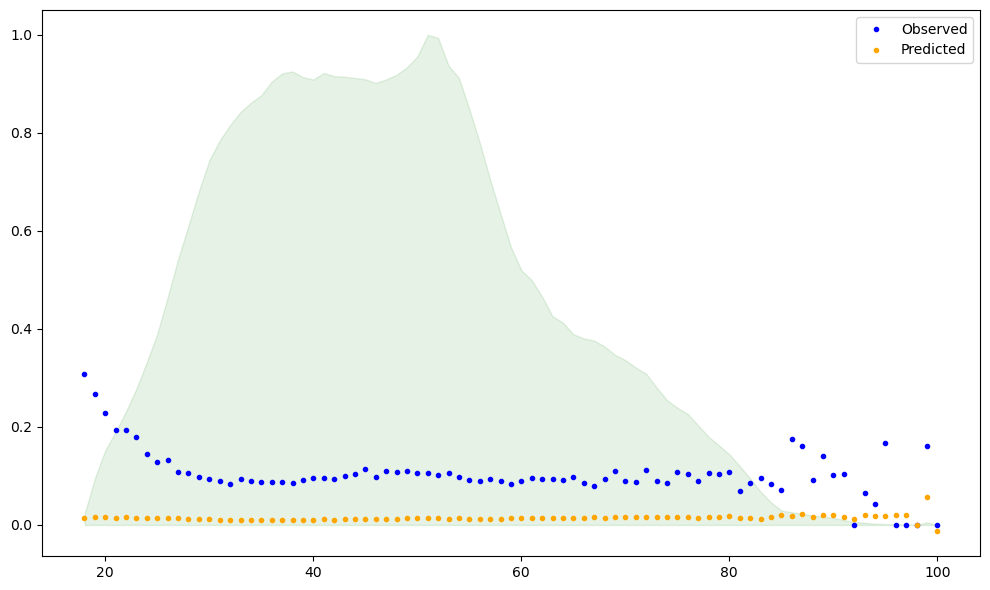

                 Generalized Linear Model Regression Results                  
Dep. Variable:                ClaimNb   No. Observations:               508509
Model:                            GLM   Df Residuals:                   508495
Model Family:                 Poisson   Df Model:                           13
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0126e+05
Date:                Sun, 11 May 2025   Deviance:                   1.5071e+05
Time:                        17:54:11   Pearson chi2:                 7.63e+05
No. Iterations:                   100   Pseudo R-squ. (CS):            0.03369
Covariance Type:            nonrobust                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -3.3645      0.045    -73.994      

ValueError: shapes (169504,105) and (14,) not aligned: 105 (dim 1) != 14 (dim 0)

In [ ]:
print(glm_ex1.summary())
pred_obs_plot(
    df= data2_df,
    feature= 'DrivAge',
    weight= 'Exposure',
    observed= 'Frequency',
    predict= glm_ex1.predict(
        exog= X_test,
    )
)

print(glm_ex2.summary())
pred_obs_plot(
    df= data2_df,
    feature= 'DrivAge',
    weight= 'Exposure',
    observed= 'Frequency',
    predict= glm_ex2.predict(
        exog= X_test,
        exposure= X_test_e
    )
)

## Modeling GLM with (Poisson, Gamma, Tweedie)

- claims -> Possion
- severity -> Gamma

- pure premiums -> Tweedie

In [ ]:
"""
Reminder!!!
- Scale:
- Log-Likelihood:
- Deviance: Measure of how good model is compared to over-fit one (lower is better)
- Pearson chi2: How well expected v.s. observed data's frequencies are statically significant.
- R^2: Proportion of variances (how much the output changes based on...) caused by the input variables.
- std err: How much the observed data deviates from model.
- z: How significant a predictor is. Tells you how many STD from the mean a value lies. 
- P>|z|: Probability of observing z compared to if were zero. (under 0.05 good)
- Link Function:
"""

"\nReminder!!!\n- Scale:\n- Log-Likelihood:\n- Deviance: Measure of how good model is compared to over-fit one (lower is better)\n- Pearson chi2: How well expected v.s. observed data's frequencies are statically significant.\n- R^2: Proportion of variances (how much the output changes based on...) caused by the input variables.\n- std err: How much the observed data deviates from model.\n- z: How significant a predictor is. Tells you how many STD from the mean a value lies. \n- P>|z|: Probability of observing z compared to if were zero. (under 0.05 good)\n- Link Function:\n"

### Poisson -> Claims